# EECS 504 Segmentation 

In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy
from google.colab.patches import cv2_imshow
from skimage import segmentation
from skimage import io, color
import skimage

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd /content/drive/MyDrive/504_project

/content/drive/.shortcut-targets-by-id/1aDjp-r3-uoqcu-Kzpsu2w2K7MS9dAy7S/504_project


# Algorithms

## Creating the superpixel maps

The code below will make superpixel maps of our three images. We use the skimage implementation of the SLIC superpixel algorithm. Here is a great medium article explaining how the algorithm works: https://medium.com/@darshita1405/superpixels-and-slic-6b2d8a6e4f08. This algorithm generates superpixels by clustering pixels based on their color similarity and proximity in the image plane. We provide a lot of functions for you. The output of the slic function is a label map (every segment has a differnt number assigned to it). 

For visualization purposed we use the function label2rgb to convert this map to a 3-channel image where every label is assigned a color. We also use the function apply_supermap to assign the color of the cluster centers to every pixel of their corresponding segmentation groups.

In [5]:
def label2rgb(labels):
  """
  Convert a labels image to an rgb image using a matplotlib colormap
  """
  label_range = np.linspace(0, 1, 256)
  lut = np.uint8(plt.cm.viridis(label_range)[:,2::-1]*256).reshape(256, 1, 3) # replace viridis with a matplotlib colormap of your choice
  return cv2.LUT(cv2.merge((labels, labels, labels)), lut)
  
def cluster_centers(superpixel_map):
  """ This function takes a superpixel map and returns a list with the 
  (row,col) positions of the cluster centers for that map"""

  x_centers = np.zeros(len(np.unique(superpixel_map)))
  y_centers = np.zeros_like(x_centers)
  counts = np.zeros_like(x_centers)
  rows, cols = superpixel_map.shape

  for row in range(rows):
    for col in range(cols):
      x_centers[superpixel_map[row, col]] += col
      y_centers[superpixel_map[row, col]] += row
      counts[superpixel_map[row, col]] += 1

  x_centers = np.round(x_centers/counts).astype('int')
  y_centers = np.round(y_centers/counts).astype('int')
  centers = list(zip(y_centers, x_centers))


  return centers
def apply_supermap(img, superpixel_map):
  """ This function returns an image where we assign the color of the cluster centers 
  to every pixel of their corresponding segmentation groups."""
  centers = cluster_centers(superpixel_map)
  out = np.zeros_like(img)
  for i,(row, col) in enumerate(centers):
    out[superpixel_map == i] = img[row, col]
  return out

##Implement color histogram
Implement the function color_histogram next. This function takes an image, a binary mask and the number of bins that you want to use for every channel. The function will compute the histogram over the 1 values in the mask only. 

##Implement adjacency matrix
Implement the adjacency matrix function that takes a superpixel map as an input and outputs a binary adjacency matrix.

In [6]:
def color_histogram(img, mask, num_bins):
  """For each channel in the image, compute a color histogram with the number of bins
  given by num_bins of the pixels in 
  image where the mask is true. Then, concatenate the vectors together into one column vector (first
  channel at top).

  Mask is a matrix of booleans the same size as image.
 
  You MUST normalize the histogram of EACH CHANNEL so that it sums to 1.
  You CAN use the numpy.histogram function.
  You MAY loop over the channels.
  The output should be a 3*num_bins vector because we have a color image and 
  you have a separate histogram per color channel.
  
  Hint: np.histogram(img[:,:,channel][mask], num_bins)"""

  rows, cols, channels = img.shape
  histogram = np.zeros(num_bins*3)

  # ===============================================
  # TODO: replace pass with your code
  masked_img = img[mask,:] # Apply mask to image to get values associate with the mask ex:90
  for i in range(channels):
    ch_hist = np.histogram(img[:,:,i][mask], num_bins)
    histogram[i*num_bins:(i+1)*num_bins] = ch_hist[0]
  # ===============================================
  histogram = histogram/masked_img.shape[0]
  return histogram

def adjacencyMatrix(superpixel_map):
  """Implement the code to compute the adjacency matrix for the superpixel map
  The input is a superpixel map and the output is a binary adjacency matrix NxN 
  (N being the number of superpixelsin svMap).  Bmap has a 1 in cell i,j if 
  superpixel i and j are neighbors. Otherwise, it has a 0.  Superpixels are neighbors 
  if any of their pixels are neighbors."""
  segmentList = np.unique(superpixel_map)
  segmentNum = len(segmentList)
  adjMatrix = np.zeros((segmentNum, segmentNum))

  # ===============================================
  # TODO: replace pass with your code
  for row in range(superpixel_map.shape[0]):
    for col in range(superpixel_map.shape[1]):
      for i in range(-1,2):
        for j in range(-1,2):
          if ((i == 0 and j == 0) or (row+i < 0) or (row+i >= superpixel_map.shape[0]) \
              or (col+ j < 0) or (col+ j >= superpixel_map.shape[1]) ):
            pass
          else:
            if (superpixel_map[row,col] != superpixel_map[row+i, col+j]):
              adjMatrix[superpixel_map[row,col], superpixel_map[row+i, col+j]] = 1
              adjMatrix[superpixel_map[row+i,col+j], superpixel_map[row, col]] = 1
  # ===============================================
  return adjMatrix

##Graph-cut algorithm

Implementation of the Ford-fulkerson algorithm which you will need to determine where your graph should be cut. You can learn more about the algorithm here: https://www.geeksforgeeks.org/ford-fulkerson-algorithm-for-maximum-flow-problem/. Please note that our version of the Ford Fulkerson algorithm doesn't return the max flow as a scalar. It returns the current flow through each edge of the graph when we reach the point of maximum flow.

We also implemented the reduce function which takes an image, its corresponding superpixel map, and a number of bins as input. The output is a list of feature vectors. Each feature vector is the resulting histogram from applying the color_histogram function you implemented to every segment on the superpixel map.

You will implement the graph_cut function 


In [7]:
from collections import deque
# Python program for implementation of Ford Fulkerson algorithm 
# The author of this code is Neelam Yadav 

from collections import defaultdict 
   
#This class represents a directed graph using adjacency matrix representation 
class Graph: 
   
    def __init__(self,graph): 
        self.graph = graph # residual graph 
        self. ROW = len(graph) 
        # self.COL = len(gr[0]) 
          
   
    '''Returns true if there is a path from source 's' to sink 't' in 
    residual graph. Also fills parent[] to store the path '''
    def BFS(self,s, t, parent): 
  
        # Mark all the vertices as not visited 
        visited =[False]*(self.ROW) 
          
        # Create a queue for BFS 
        queue=[] 
          
        # Mark the source node as visited and enqueue it 
        queue.append(s) 
        visited[s] = True
           
         # Standard BFS Loop 
        while queue: 
  
            #Dequeue a vertex from queue and print it 
            u = queue.pop(0) 
          
            # Get all adjacent vertices of the dequeued vertex u 
            # If a adjacent has not been visited, then mark it 
            # visited and enqueue it 
            for ind, val in enumerate(self.graph[u]): 
                if visited[ind] == False and val > 0 : 
                    queue.append(ind) 
                    visited[ind] = True
                    parent[ind] = u 
  
        # If we reached sink in BFS starting from source, then return 
        # true, else false 
        return True if visited[t] else False
              
      
    # Returns tne current flow from s to t in the given graph 
    def FordFulkerson(self, source, sink): 
  
        # This array is filled by BFS and to store path 
        parent = [-1]*(self.ROW) 
  
        max_flow = 0 # There is no flow initially 
        current_flow = np.zeros_like(self.graph)
  
        # Augment the flow while there is path from source to sink 
        while self.BFS(source, sink, parent) : 
            # Find minimum residual capacity of the edges along the 
            # path filled by BFS. Or we can say find the maximum flow 
            # through the path found. 
            path_flow = float("Inf") 
            s = sink 
            while(s !=  source): 
                path_flow = min (path_flow, self.graph[parent[s]][s]) 
                s = parent[s] 
  
            # Add path flow to overall flow 
            max_flow +=  path_flow 
  
            # update residual capacities of the edges and reverse edges 
            # along the path 
            v = sink 
            while(v !=  source): 
                u = parent[v] 
                self.graph[u][v] -= path_flow 
                self.graph[v][u] += path_flow 
                current_flow[u][v] += path_flow 
                current_flow[v][u] -= path_flow 
                v = parent[v] 

        return current_flow

def reduce(img, superpixel_map, num_bins=10):
  """This function takes as input an image, its corresponding superpixel map, and a 
  number of bins as input. The output is a list of feature vectors. 
  Each feature vector is the resulting histogram from applying the color_histogram 
  function you implemented to every segment on the superpixel map."""

  feature_vectors = []
  num_segments = len(np.unique(superpixel_map))
  for i in range(num_segments):
      mask = superpixel_map == i
      feature_vectors.append(color_histogram(img, mask, num_bins))
  return(feature_vectors)
  
def graph_cut(superpixel_map, features, centers, keyindex):
  """Function to take a superpixel set and a keyindex and convert to a 
  foreground/background segmentation.
  
  keyindex is the index to the superpixel segment we wish to use as foreground and
  find its relevant neighbors.
  
  centers is a list of tuples (row, col) with the positions of the cluster centers 
  of the superpixel_map

  features is a list of histograms (obtained from the reduce function) for every superpixel
  segment in an image.
  
  """

  #Compute basic adjacency information of superpixels
  #Note that adjacencyMatrix is code you need to implement

  # ===============================================
  # TODO: this should be one line of code
  adjMatrix = adjacencyMatrix(superpixel_map)
  # ===============================================
  

  # normalization for distance calculation based on the image size
  # for points (x1,y1) and (x2,y2), distance is
  # exp(-||(x1,y1)-(x2,y2)||^2/dnorm)
  dnorm = 2*(superpixel_map.shape[0]/2 *superpixel_map.shape[1] /2)**2
  k = len(features) #number of superpixels in image

  #Generate capacity matrix
  capacity = np.zeros((k+2,k+2))
  source = k
  sink = k+1

  # This is a single planar graph with an extra source and sink
  #  Capacity of a present edge in the graph is to be defined as the product of
  #  1:  the histogram similarity between the two color histogram feature vectors.
  #  The similarity between histograms should be computed as the intersections between 
  #  the histograms. i.e: sum(min(histogram 1, histogram 2))
  #  2:  the spatial proximity between the two superpixels connected by the edge.
  #      use exp(-||(x1,y1)-(x2,y2)||^2/dnorm) 
  #      
  #  Source gets connected to every node except sink
  #  Capacity is with respect to the keyindex superpixel
  #  Sink gets connected to every node except source and its capacity is opposite 
  # The weight between a pixel and the sink is going to be the max of all the weights between 
  # the source and the image pixels minus the weight between that specific pixel and the source.
  # Other superpixels get connected to each other based on computed adjacency
  # matrix: the capacity is defined as above, EXCEPT THAT YOU ALSO NEED TO MULTIPLY BY A SCALAR 0.25 for
  # adjacent superpixels.


  key_features = features[keyindex] # color histogram representation of superpixel # keyindex
  key_x = centers[keyindex][1] # row of cluster center for superpixel # keyindex
  key_y = centers[keyindex][0] # col of cluster center for superpixel # keyindex

  # ===============================================
  # TODO: Generate the capacity matrix using the description above. Replace pass with your code
  # Find the max weight between pixel and source/sink
  max = 0
  for i in range(k):
    #1: Histogram similarity
    sim_hist = np.sum(np.minimum(features[i],key_features))
    #2: Spatial proximity
    dist = np.array(centers[i]) - np.array(centers[keyindex])
    sim_spat = np.exp(-1 * np.linalg.norm(dist, ord=2)/dnorm)
    edge_capacity = sim_hist * sim_spat
    # edge_capacity = sim_spat
    if (edge_capacity > max):
      max = edge_capacity

  for i in range(k):
    for j in range(i+1,k):
      #1: Histogram similarity
      sim_hist = np.sum(np.minimum(features[i],features[j]))
      #2: Spatial proximity
      dist = np.array(centers[i]) - np.array(centers[j])
      sim_spat = np.exp(-1 * np.linalg.norm(dist, ord=2)/dnorm)
      edge_capacity = sim_hist * sim_spat
      # edge_capacity = sim_spat
      if i==keyindex:
          capacity[source,j] = edge_capacity
          capacity[j,source] = edge_capacity
          capacity[sink,j] = max - edge_capacity
          capacity[j,sink] = max - edge_capacity
      elif j==keyindex:
          capacity[source,i] = edge_capacity
          capacity[i,source] = edge_capacity
          capacity[sink,i] = max - edge_capacity
          capacity[i,sink] = max - edge_capacity
      if adjMatrix[i,j] == 1:
        # capacity[i][j] = 0.25 * edge_capacity
        # capacity[j][i] = 0.25 * edge_capacity
        capacity[i][j] = 0.01 * edge_capacity
        capacity[j][i] = 0.01 * edge_capacity
  # Sink and source not connected
  capacity[sink, keyindex] = 0
  capacity[keyindex, sink] = 0
  capacity[source, keyindex] = max
  capacity[keyindex, source] = max 

  # ===============================================    
  # Obtaining the current flow of the graph when the flow is max
  g = Graph(capacity.copy()) 
  current_flow = g.FordFulkerson(source, sink)
  
  # Extract the two-class segmentation.
  # the cut will separate all nodes into those connected to the
  # source and those connected to the sink.
  # The current_flow matrix contains the necessary information about
  # the max-flow through the graph.
  segment_map = np.zeros_like(superpixel_map)
  rem_capacity = capacity - current_flow

  # ===============================================
  # TODO: Do the segmentation and fill segmentation map with 1s where the foreground is.
  # Replace pass with your code
  queue = deque([source])
  reachable = np.zeros(k)
  while(len(queue) != 0):
    node = queue.popleft()
    for i in range(k):
      if (reachable[i] == 0):
        if (rem_capacity[node,i] > 0):
          reachable[i] = 1
          queue.append(i)
  rechable_idx = np.argwhere(reachable == 1).reshape(-1)
  for i in range(len(rechable_idx)):
      cur_idx = (superpixel_map==rechable_idx[i])
      segment_map[cur_idx] = 1
  # ===============================================
  
  return capacity, segment_map

# Retailer Photo simple

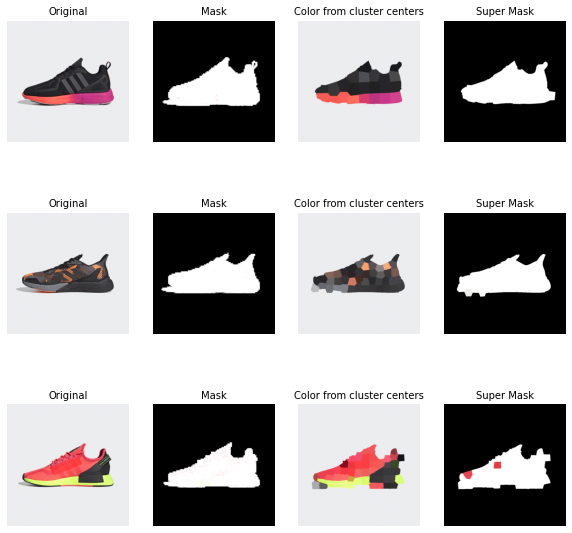

In [8]:
# Read the images
shoes1 = plt.imread('Retailer Photos/Nam Gyu Kil/Adidas/fx2044_black/left.jpg')/255
shoes1 = shoes1[:,:,:3]
shoes2 = plt.imread('Retailer Photos/Nam Gyu Kil/Adidas/zx_2k_orange/left.jpg')/255
shoes2 = shoes2[:,:,:3]
shoes3 = plt.imread('Retailer Photos/Nam Gyu Kil/Adidas/nmd_r1_v2_pink/left.jpg')/255
shoes3 = shoes3[:,:,:3]

# Apply color mask corresponding to bottom left corner
ind_shoes1 = np.where(np.all(shoes1 == shoes1[0,0], axis=-1))
ind_shoes2 = np.where(np.all(shoes2 == shoes2[0,0], axis=-1))
ind_shoes3 = np.where(np.all(shoes3 == shoes3[0,0], axis=-1))
ind_not_shoes1 = np.where(np.all(shoes1 != shoes1[0,0], axis=-1))
ind_not_shoes2 = np.where(np.all(shoes2 != shoes2[0,0], axis=-1))
ind_not_shoes3 = np.where(np.all(shoes3 != shoes3[0,0], axis=-1))
mask_shoes1 = np.copy(shoes1)
mask_shoes2 = np.copy(shoes2)
mask_shoes3 = np.copy(shoes3)
mask_shoes1[ind_shoes1[0], ind_shoes1[1],:] = 0
mask_shoes2[ind_shoes2[0], ind_shoes2[1],:] = 0
mask_shoes3[ind_shoes3[0], ind_shoes3[1],:] = 0
mask_shoes1[ind_not_shoes1[0], ind_not_shoes1[1],:] = 1
mask_shoes2[ind_not_shoes2[0], ind_not_shoes2[1],:] = 1
mask_shoes3[ind_not_shoes3[0], ind_not_shoes3[1],:] = 1

# Super Pixel 
super_shoes1 = segmentation.slic(shoes1, n_segments=144, compactness=100, max_iter=5)
super_shoes2 = segmentation.slic(shoes2, n_segments=288, compactness=100, max_iter=20)
super_shoes3 = segmentation.slic(shoes3, n_segments=288, compactness=100, max_iter=5)

# Super Pixel Masking (cc cluster center)
super_shoes_cc1 = apply_supermap(shoes1, super_shoes1)
super_shoes_cc2 = apply_supermap(shoes2, super_shoes2)
super_shoes_cc3 = apply_supermap(shoes3, super_shoes3)
ind_super_shoes1 = np.where(np.all(super_shoes_cc1 == super_shoes_cc1[0,0], axis=-1))
ind_super_shoes2 = np.where(np.all(super_shoes_cc2 == super_shoes_cc2[0,0], axis=-1))
ind_super_shoes3 = np.where(np.all(super_shoes_cc3 == super_shoes_cc3[0,0], axis=-1))
ind_not_super_shoes1 = np.where(np.all(super_shoes_cc1 != super_shoes_cc1[0,0], axis=-1))
ind_not_super_shoes2 = np.where(np.all(super_shoes_cc2 != super_shoes_cc2[0,0], axis=-1))
ind_not_super_shoes3 = np.where(np.all(super_shoes_cc3 != super_shoes_cc3[0,0], axis=-1))
mask_super_shoes1 = np.copy(super_shoes_cc1)
mask_super_shoes2 = np.copy(super_shoes_cc2)
mask_super_shoes3 = np.copy(super_shoes_cc3)
mask_super_shoes1[ind_super_shoes1[0], ind_super_shoes1[1],:] = 0
mask_super_shoes2[ind_super_shoes2[0], ind_super_shoes2[1],:] = 0
mask_super_shoes3[ind_super_shoes3[0], ind_super_shoes3[1],:] = 0
mask_super_shoes1[ind_not_super_shoes1[0], ind_not_super_shoes1[1],:] = 1
mask_super_shoes2[ind_not_super_shoes2[0], ind_not_super_shoes2[1],:] = 1
mask_super_shoes3[ind_not_super_shoes3[0], ind_not_super_shoes3[1],:] = 1

# Plot
fig, ax = plt.subplots(3, 4, figsize=(10,10))
images = [shoes1, shoes2, shoes3]
masks = [mask_shoes1, mask_shoes2, mask_shoes3]
super_images = [super_shoes1, super_shoes2, super_shoes3]
super_masks = [mask_super_shoes1, mask_super_shoes2, mask_super_shoes3]
for i,a in enumerate(ax):
  a[0].set_axis_off()
  a[0].set_title('Original', fontsize=10)
  a[0].imshow(images[i])
  a[1].set_axis_off()
  a[1].set_title('Mask', fontsize=10)
  a[1].imshow(masks[i])
  a[2].set_axis_off()
  a[2].set_title('Color from cluster centers', fontsize=10)
  a[2].imshow(apply_supermap(images[i], super_images[i]))
  a[3].set_axis_off()
  a[3].set_title('Super Mask', fontsize=10)
  a[3].imshow(super_masks[i])

# User Photo

## Simple Implementation

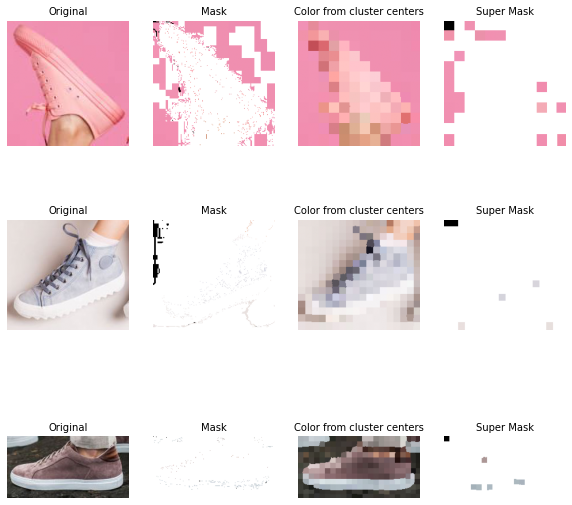

In [9]:
# Read the images
shoes1 = plt.imread('User Photos/_Thomas/left01.jpg')/255
shoes1 = shoes1[:,:,:3]
shoes2 = plt.imread('User Photos/_Thomas/left02.jpg')/255
shoes2 = shoes2[:,:,:3]
shoes3 = plt.imread('User Photos/_Thomas/left04.jpg')/255
shoes3 = shoes3[:,:,:3]

# Apply color mask corresponding to bottom left corner
ind_shoes1 = np.where(np.all(shoes1 == shoes1[0,0], axis=-1))
ind_shoes2 = np.where(np.all(shoes2 == shoes2[0,0], axis=-1))
ind_shoes3 = np.where(np.all(shoes3 == shoes3[0,0], axis=-1))
ind_not_shoes1 = np.where(np.all(shoes1 != shoes1[0,0], axis=-1))
ind_not_shoes2 = np.where(np.all(shoes2 != shoes2[0,0], axis=-1))
ind_not_shoes3 = np.where(np.all(shoes3 != shoes3[0,0], axis=-1))
mask_shoes1 = np.copy(shoes1)
mask_shoes2 = np.copy(shoes2)
mask_shoes3 = np.copy(shoes3)
mask_shoes1[ind_shoes1[0], ind_shoes1[1],:] = 0
mask_shoes2[ind_shoes2[0], ind_shoes2[1],:] = 0
mask_shoes3[ind_shoes3[0], ind_shoes3[1],:] = 0
mask_shoes1[ind_not_shoes1[0], ind_not_shoes1[1],:] = 1
mask_shoes2[ind_not_shoes2[0], ind_not_shoes2[1],:] = 1
mask_shoes3[ind_not_shoes3[0], ind_not_shoes3[1],:] = 1

# Super Pixel 
super_shoes1 = segmentation.slic(shoes1, n_segments=144, compactness=100, max_iter=5)
super_shoes2 = segmentation.slic(shoes2, n_segments=288, compactness=100, max_iter=20)
super_shoes3 = segmentation.slic(shoes3, n_segments=288, compactness=100, max_iter=5)

# Super Pixel Masking (cc cluster center)
super_shoes_cc1 = apply_supermap(shoes1, super_shoes1)
super_shoes_cc2 = apply_supermap(shoes2, super_shoes2)
super_shoes_cc3 = apply_supermap(shoes3, super_shoes3)
ind_super_shoes1 = np.where(np.all(super_shoes_cc1 == super_shoes_cc1[0,0], axis=-1))
ind_super_shoes2 = np.where(np.all(super_shoes_cc2 == super_shoes_cc2[0,0], axis=-1))
ind_super_shoes3 = np.where(np.all(super_shoes_cc3 == super_shoes_cc3[0,0], axis=-1))
ind_not_super_shoes1 = np.where(np.all(super_shoes_cc1 != super_shoes_cc1[0,0], axis=-1))
ind_not_super_shoes2 = np.where(np.all(super_shoes_cc2 != super_shoes_cc2[0,0], axis=-1))
ind_not_super_shoes3 = np.where(np.all(super_shoes_cc3 != super_shoes_cc3[0,0], axis=-1))
mask_super_shoes1 = np.copy(super_shoes_cc1)
mask_super_shoes2 = np.copy(super_shoes_cc2)
mask_super_shoes3 = np.copy(super_shoes_cc3)
mask_super_shoes1[ind_super_shoes1[0], ind_super_shoes1[1],:] = 0
mask_super_shoes2[ind_super_shoes2[0], ind_super_shoes2[1],:] = 0
mask_super_shoes3[ind_super_shoes3[0], ind_super_shoes3[1],:] = 0
mask_super_shoes1[ind_not_super_shoes1[0], ind_not_super_shoes1[1],:] = 1
mask_super_shoes2[ind_not_super_shoes2[0], ind_not_super_shoes2[1],:] = 1
mask_super_shoes3[ind_not_super_shoes3[0], ind_not_super_shoes3[1],:] = 1

# Plot
fig, ax = plt.subplots(3, 4, figsize=(10,10))
images = [shoes1, shoes2, shoes3]
masks = [mask_shoes1, mask_shoes2, mask_shoes3]
super_images = [super_shoes1, super_shoes2, super_shoes3]
super_masks = [mask_super_shoes1, mask_super_shoes2, mask_super_shoes3]
for i,a in enumerate(ax):
  a[0].set_axis_off()
  a[0].set_title('Original', fontsize=10)
  a[0].imshow(images[i])
  a[1].set_axis_off()
  a[1].set_title('Mask', fontsize=10)
  a[1].imshow(masks[i])
  a[2].set_axis_off()
  a[2].set_title('Color from cluster centers', fontsize=10)
  a[2].imshow(apply_supermap(images[i], super_images[i]))
  a[3].set_axis_off()
  a[3].set_title('Super Mask', fontsize=10)
  a[3].imshow(super_masks[i])

##Visualizing SLIC superpixel maps

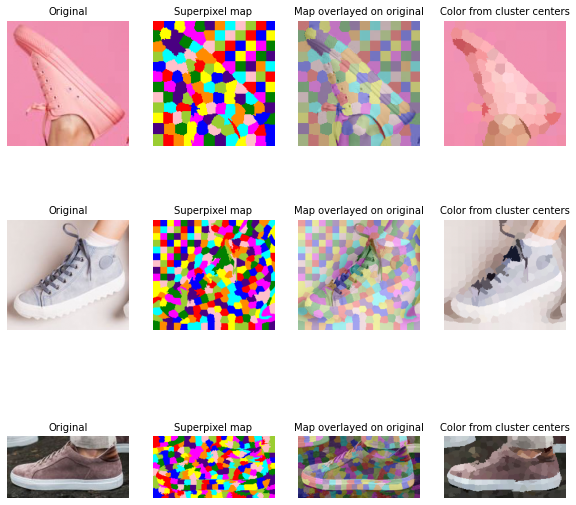

In [10]:
# shoes1 = plt.imread('Retailer Photos/Mu-Ti Chung/NewBalance/ml584egn/left.jpg')/255
# # shoes1 = plt.imread('Retailer Photos/Nam Gyu Kil/Adidas/fx2044_black/left.jpg')/255
# shoes1 = shoes1[:,:,:3]
# shoes2 = plt.imread('Retailer Photos/Nam Gyu Kil/Adidas/zx_2k_orange/left.jpg')/255
# shoes2 = shoes2[:,:,:3]
# shoes3 = plt.imread('Retailer Photos/Nam Gyu Kil/Adidas/nmd_r1_v2_pink/left.jpg')/255
# shoes3 = shoes3[:,:,:3]

shoes1 = plt.imread('User Photos/_Thomas/left01.jpg')/255
shoes1 = shoes1[:,:,:3]
shoes2 = plt.imread('User Photos/_Thomas/left02.jpg')/255
shoes2 = shoes2[:,:,:3]
shoes3 = plt.imread('User Photos/_Thomas/left04.jpg')/255
shoes3 = shoes3[:,:,:3]

super_shoes1 = segmentation.slic(shoes1, n_segments=144, compactness=25, max_iter=20)
super_shoes2 = segmentation.slic(shoes2, n_segments=288, compactness=10, max_iter=20)
super_shoes3 = segmentation.slic(shoes3, n_segments=288, compactness=10, max_iter=20)

fig, ax = plt.subplots(3, 4, figsize=(10,10))
images = [shoes1, shoes2, shoes3]
maps = [super_shoes1, super_shoes2, super_shoes3]

for i,a in enumerate(ax):
  a[0].set_axis_off()
  a[0].set_title('Original', fontsize=10)
  a[0].imshow(images[i])
  a[1].set_axis_off()
  a[1].set_title('Superpixel map', fontsize=10)
  a[1].imshow(skimage.color.label2rgb(maps[i]))
  a[2].set_axis_off()
  a[2].set_title('Map overlayed on original', fontsize=10)
  a[2].imshow(skimage.color.label2rgb(maps[i], images[i]))
  a[3].set_axis_off()
  a[3].set_title('Color from cluster centers', fontsize=10)
  a[3].imshow(apply_supermap(images[i], maps[i]))

##Visualizing graphcut segmentation

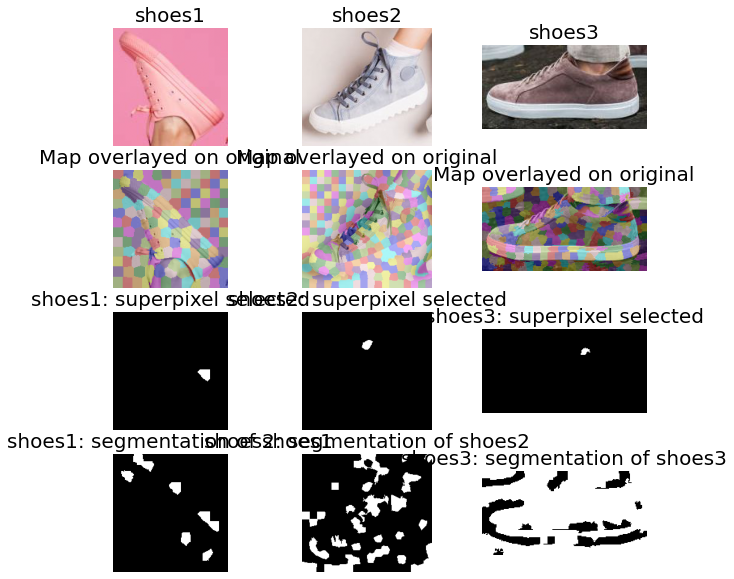

In [11]:
shoes1_features = reduce(shoes1, super_shoes1)
shoes1_centers = cluster_centers(super_shoes1)
shoes1_capacity, shoes1_segment_map = graph_cut(super_shoes1, shoes1_features, shoes1_centers, 80)

shoes2_features = reduce(shoes2, super_shoes2)
shoes2_centers = cluster_centers(super_shoes2)
shoes2_capacity,shoes2_segment_map = graph_cut(super_shoes2, shoes2_features, shoes2_centers, 75)

shoes3_features = reduce(shoes3, super_shoes3)
shoes3_centers = cluster_centers(super_shoes3)
shoes3_capacity,shoes3_segment_map = graph_cut(super_shoes3, shoes3_features, shoes3_centers, 60)

fig, ax = plt.subplots(4, 3, figsize=(10,10))
ax[0][0].set_axis_off()
ax[0][0].set_title('shoes1', fontsize=20)
ax[0][0].imshow(shoes1, cmap="gray")
ax[0][1].set_axis_off()
ax[0][1].set_title('shoes2', fontsize=20)
ax[0][1].imshow(shoes2, cmap="gray")
ax[0][2].set_axis_off()
ax[0][2].set_title('shoes3', fontsize=20)
ax[0][2].imshow(shoes3, cmap="gray")

ax[1][0].set_axis_off()
ax[1][0].set_title('Map overlayed on original', fontsize=20)
ax[1][0].imshow(skimage.color.label2rgb(super_shoes1, shoes1))
ax[1][1].set_axis_off()
ax[1][1].set_title('Map overlayed on original', fontsize=20)
ax[1][1].imshow(skimage.color.label2rgb(super_shoes2, shoes2))
ax[1][2].set_axis_off()
ax[1][2].set_title('Map overlayed on original', fontsize=20)
ax[1][2].imshow(skimage.color.label2rgb(super_shoes3, shoes3))

ax[2][0].set_axis_off()
ax[2][0].set_title('shoes1: superpixel selected', fontsize=20)
ax[2][0].imshow(super_shoes1==80, cmap="gray")
ax[2][1].set_axis_off()
ax[2][1].set_title('shoes2: superpixel selected', fontsize=20)
ax[2][1].imshow(super_shoes2==75, cmap="gray")
ax[2][2].set_axis_off()
ax[2][2].set_title('shoes3: superpixel selected', fontsize=20)
ax[2][2].imshow(super_shoes3==60, cmap="gray")

ax[3][0].set_axis_off()
ax[3][0].set_title('shoes1: segmentation of shoes1', fontsize=20)
ax[3][0].imshow(shoes1_segment_map, cmap="gray")
ax[3][1].set_axis_off()
ax[3][1].set_title('shoes2: segmentation of shoes2', fontsize=20)
ax[3][1].imshow(shoes2_segment_map, cmap="gray")
ax[3][2].set_axis_off()
ax[3][2].set_title('shoes3: segmentation of shoes3', fontsize=20)
ax[3][2].imshow(shoes3_segment_map, cmap="gray")

## Grab Cut Base

(-0.5, 203.5, 103.5, -0.5)

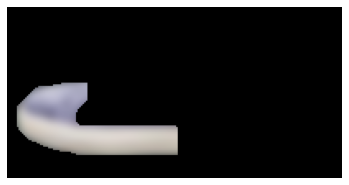

In [21]:
import cv2 as cv
shoe_num = '04'
b_super = False
b_blur = True
blur = 15
# Good
img = cv.imread('User Photos/_Thomas/left01.jpg')
img = cv.imread('User Photos/_Thomas/left09.jpg')
# Work with Convex
img = cv.imread('User Photos/_Thomas/left04.jpg') # With super 1000
img = cv.imread('User Photos/_Thomas/left06.jpg') # With blur
img = cv.imread('User Photos/_Thomas/left10.jpg') # With blur
img = cv.imread('User Photos/_Thomas/left13.jpg') # Alright with blur
# img = cv.imread('User Photos/_Thomas/left18.jpg')

# Bad
# img = cv.imread('User Photos/_Thomas/left02.jpg')
# img = cv.imread('User Photos/_Thomas/left07.jpg')
# img = cv.imread('User Photos/_Thomas/left08.jpg')
img = cv.imread('User Photos/_Thomas/left14.jpg') # GOod with blur

img = cv.imread('User Photos/_Thomas/left' + shoe_num + '.jpg')
# # Super Pixel
if b_super == True:
  super_img = segmentation.slic(img, n_segments=1000, compactness=15, max_iter=20)
  img = apply_supermap(img, super_img)
elif b_blur == True:
  img = cv.GaussianBlur(img,(blur,blur),0)
  # img = cv.bilateralFilter(img,9,75,75)

mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (1,1,img.shape[0]-1,img.shape[1]-1)
cv.grabCut(img,mask,rect,bgdModel,fgdModel,50,cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
plt.imshow(img)
plt.axis('off')
# plt.colorbar(),plt.show()

## SIFT

In [13]:
!pip install opencv-python==3.3.0.10 opencv-contrib-python==3.3.0.10

(-0.5, 138.5, 101.5, -0.5)

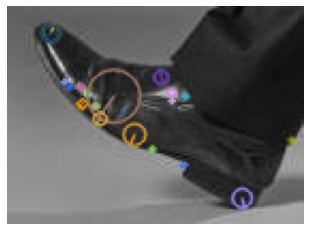

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = cv.imread('User Photos/_Thomas/left' + shoe_num + '.jpg')
# Super Pixel
if b_super == True:
  super_img = segmentation.slic(img, n_segments=10000, compactness=15, max_iter=20)
  img = apply_supermap(img, super_img)
# if b_blur == True:
#   img = cv.GaussianBlur(img,(blur,blur),0)
  # img = cv.bilateralFilter(img,9,75,75)
#read the iamge and convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#create sift object
sift  = cv2.xfeatures2d.SIFT_create(25)
#calculate keypoints and their orientation
keypoints,descriptors = sift.detectAndCompute(gray,None)
#plot keypoints on the image
with_keypoints = cv2.drawKeypoints(gray,keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#plot the image
plt.imshow(with_keypoints)
plt.axis('off')

## Convex Hull

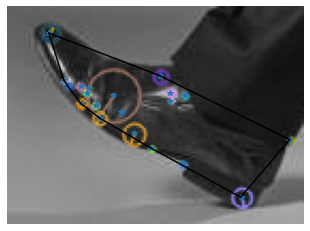

In [15]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import pdb 

pts = np.zeros((len(keypoints),2))
for i in range(len(keypoints)):
  pts[i,0] = int(keypoints[i].pt[0])
  pts[i,1] = int(keypoints[i].pt[1])
# Convex Hull
hull = ConvexHull(pts, True)
hull_indices = hull.vertices

# Plot
plt.imshow(with_keypoints)
plt.plot(pts[:,0],pts[:,1],'*') 
for simplex in hull.simplices:
  plt.plot(pts[simplex, 0], pts[simplex, 1], 'k-')
plt.axis('off')
# Fill Polygon
from skimage.draw import polygon
new_x, new_y = polygon(pts[hull_indices,0],pts[hull_indices,1])
# plt.plot(new_x, new_y)
# plt.xlim(0, img.shape[0])
# plt.ylim(0, img.shape[1])
# plt.gca().invert_yaxis()

## Grab Cut with Convex

(-0.5, 138.5, 101.5, -0.5)

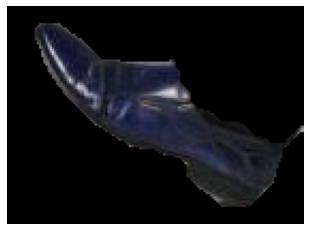

In [16]:
import cv2 as cv
mask = np.ones(img.shape[:2],np.uint8) * 2
mask[new_y, new_x] = 3
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (1,1,img.shape[0]-1,img.shape[1]-1)
if b_blur == True:
  img = cv.GaussianBlur(img,(blur,blur),0)
  # img = cv.bilateralFilter(img,9,75,75)
cv.grabCut(img,mask,rect,bgdModel,fgdModel,10,cv.GC_INIT_WITH_MASK)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = cv.imread('User Photos/_Thomas/left' + shoe_num + '.jpg')
img = img*mask2[:,:,np.newaxis]
plt.imshow(img)
#plt.colorbar(),plt.show()
plt.axis('off')

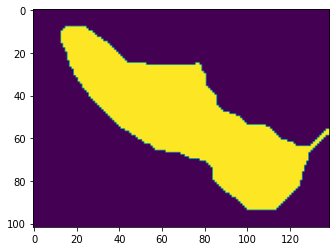

In [17]:
plt.imshow(mask)

## Concave Hull

In [18]:
# !pip3 install alphashape
from descartes import PolygonPatch
alpha_shape = alphashape.alphashape(pts, 0.0)
fig, ax = plt.subplots()
ax.scatter(*zip(*pts))
ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))
ax.invert_yaxis()
plt.show()


ModuleNotFoundError: ignored

# Minimum Spanning Forest

In [ ]:
def compute_MSF_edges(superpixel_map, adjMatrix, centers, features):
  """ For this function you will turn the adjacency matrix into a  mx3 matrix, 
  of which each row is an edge (node1, node2, weights). You will return this matrix.
  
  m is the number of edges. You should avoid duplicated edges. You will only use
  the edges where the adjacency matrix is 1 (between neighbors)
  
  The edge weight is defined as the product of (1) difference of histograms
  (or equivalently, 1-intersection of histograms/3), and (2) inverse
  proximity exp(D(a,b)) with D specified below.
  Notice the difference between the weights here and those in graph cuts.

  Normalization for distance calculation based on the image size
  For points (x1,y1) and (x2,y2), normalized distance D =
  ||(x1,y1)-(x2,y2)||^2/dnorm.   
  
  hint: np.triu, np.where (you don't necessarily need to use these)"""


  rows, cols = superpixel_map.shape
  dnorm = np.sum(rows**2 + cols**2)
  n, _  = adjMatrix.shape
  G = []
  
  # ===============================================
  # TODO: Replace pass with your code
  for i in range(n):
    for j in range(i+1,n):
      if adjMatrix[i,j] == 1:
        # difference of histograms
        sim_hist = 1.0 - np.sum(np.minimum(features[i],features[j]))/3.0
        # inverse proximity
        dist = np.array(centers[i]) - np.array(centers[j])
        sim_spat = np.exp(np.linalg.norm(dist, ord=2)**2/dnorm)
        edge_weight = sim_hist * sim_spat
        G.append(np.array([i, j, edge_weight]))
  G = np.array(G)
  
  # ===============================================
  
  return G

def filter_segments(edges, seg_id, min_size):
  """A common postprocessing step used with F-H is to merge all of the small, unnecessary components that result from uneven
  regions. This function should 1) iterate through the edges, in
  ascending order, and 2) for each edge, if it connects two distinct segments, AND if at least one of those segments contains less
  than min_size pixels in it, merge the segments. 
  
  You will change seg_id and return it. This function will be used in MSF. 
  """

  num_edges = edges.shape[0]
  # ===============================================
  # # TODO: Replace pass with your code
  num_nodes = int(np.max(edges[:,:2])) +1
  for edge in edges:
    seg1 = seg_id[int(edge[0])]
    seg2 = seg_id[int(edge[1])]
    if (seg1 != seg2):
      num_px_seg1 = len(np.argwhere(seg_id == seg1).reshape(-1))
      num_px_seg2 = len(np.argwhere(seg_id == seg2).reshape(-1))
      if (num_px_seg1 < min_size or num_px_seg2 < min_size):
        idx_seg2 = np.argwhere(seg_id == seg2).reshape(-1)
        seg_id[idx_seg2] = seg1
  # ===============================================

  return seg_id

def nodesInSegment(seg_id, S):
  nodes_in_S_idx = np.argwhere(seg_id == S).reshape(-1)
  nodes_cnt = len(nodes_in_S_idx)
  return nodes_cnt

def MSF(edges, k, filter_min_size=None):
  """Felzenszwalb-Huttenlocher algorithm implementation, which is a modified
  version of the Kruskal algorithm.
  Input  edges: mx3 matrix, the adjacency list of a graph, of which each row is 
            an edge (node1, node2, weights). 
         m: is the number of edges.
         k: hyperparameter for F-H algorithm
         filter_size: if a filter size is passed, this will remove groups from the 
         segmentation that have less than filter_size superpixels
  Output seg: array of size (n,), the segment id assigned to each node in the graph
              n is the number of nodes"""

  num_edges = edges.shape[0]
  num_nodes = int(np.max(edges[:,:2])) +1

  # Sort edges in ascending order
  edges = edges[np.argsort(edges[:,2]), :]
 
  # You will assign every pixel to the id corresponding to a segment id. Initially,
  # every superpixel is in its own segment.
  seg_id = np.array(list(range(num_nodes)))

  # ===============================================
  # TODO: Replace pass with your code
  seg_weights = np.zeros(seg_id.shape)
  for edge in edges:
    node1 = seg_id[int(edge[0])]
    node2 = seg_id[int(edge[1])]
    if (node1 != node2):
      # Calculate Weights of edge and Segements
      edge_weight = edge[2]
      S1_cnt = nodesInSegment(seg_id, node1)
      S2_cnt = nodesInSegment(seg_id, node2)
      S1_max_weight = seg_weights[node1]
      S2_max_weight = seg_weights[node2]
      MIntS1S2 = min([S1_max_weight + k/S1_cnt, S2_max_weight + k/S2_cnt])
      if (edge_weight < MIntS1S2):
        nodes_in_node2_idx = np.argwhere(seg_id == node2).reshape(-1)
        seg_id[nodes_in_node2_idx] = node1
        if (edge_weight > seg_weights[node1]):
          seg_weights[node1] = edge_weight
  # ===============================================
  if filter:
    # Postprocessing to remove fragments
    seg_id = filter_segments(edges, seg_id, filter_min_size)
      

  return seg_id 

def build_msf_map(segmentation, superpixel_map):
  num_nodes = len(segmentation)
  map = np.zeros_like(superpixel_map)
  rows, cols = map.shape
  for row in range(rows):
    for col in range(cols):
      map[row, col] = segmentation[superpixel_map[row, col]]
  return map

In [ ]:
edges_shoes1 = compute_MSF_edges(super_shoes1, adjMatrix_shoes1, shoes1_centers, shoes1_features)
edges_shoes2 = compute_MSF_edges(super_shoes2, adjMatrix_shoes2, shoes2_centers, shoes2_features)
# edges_shoes3 = compute_MSF_edges(super_shoes3, adjMatrix_shoes3, shoes3_centers, shoes3_features)

segmentation_shoes1 = MSF(edges_shoes1,1, 0)
segmentation_shoes2 = MSF(edges_shoes2,1, 0)
# segmentation_shoes3 = MSF(edges_shoes3,4, 0)

shoes1_map = build_msf_map(segmentation_shoes1, super_shoes1)
shoes2_map = build_msf_map(segmentation_shoes2, super_shoes2)
# shoes3_map = build_msf_map(segmentation_shoes3, super_shoes3)

segmentation_shoes1 = MSF(edges_shoes1,1, 5)
segmentation_shoes2 = MSF(edges_shoes2,1, 3)
# segmentation_shoes3 = MSF(edges_shoes3,4, 15)

shoes1_map_filtered = build_msf_map(segmentation_shoes1, super_shoes1)
shoes2_map_filtered = build_msf_map(segmentation_shoes2, super_shoes2)
# shoes3_map_filtered = build_msf_map(segmentation_shoes3, super_shoes3)


fig, ax = plt.subplots(3, 3, figsize=(25,25))

ax[0][0].set_axis_off()
ax[0][0].set_title('Shoes1', fontsize=20)
ax[0][0].imshow(shoes1)
ax[0][1].set_axis_off()
ax[0][1].set_title('Shoes2', fontsize=20)
ax[0][1].imshow(shoes2)
ax[0][2].set_axis_off()
ax[0][2].set_title('Shoes3', fontsize=20)
ax[0][2].imshow(shoes3)
ax[0][2].set_axis_off()

ax[1][0].set_axis_off()
ax[1][0].set_title('Shoes1: segmentation', fontsize=20)
ax[1][0].imshow(shoes1_map)
ax[1][1].set_axis_off()
ax[1][1].set_title('Shoes2: segmentation', fontsize=20)
ax[1][1].imshow(shoes2_map)
ax[1][2].set_axis_off()
ax[1][2].set_title('Shoes3: segmentation', fontsize=20)
ax[1][2].imshow(shoes3_map)
ax[1][2].set_axis_off()

ax[2][0].set_axis_off()
ax[2][0].set_title('Shoes1: segmentation filtered', fontsize=20)
ax[2][0].imshow(shoes1_map_filtered)
ax[2][1].set_axis_off()
ax[2][1].set_title('Shoes2: segmentation filtered', fontsize=20)
ax[2][1].imshow(shoes2_map_filtered)
ax[2][2].set_axis_off()
ax[2][2].set_title('Shoes3: segmentation filtered', fontsize=20)
ax[2][2].imshow(shoes3_map_filtered)
ax[2][2].set_axis_off()